In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy
import pywt
from pathlib import Path

In [14]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**8
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 256
Range resolution 0.04
Range bin 0.04303617205204089
Max range 11.017260045322468


In [15]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [16]:
#calculate the peak index on each chirp
def get_the_peaks(magnitude_matrix):
    print("shape of input: {0}".format(magnitude_matrix.shape))
    peak_indices=[]
    rows =range(0,magnitude_matrix.shape[0])
    for r in rows:
        peak_index = np.argmax(magnitude_matrix[r,1:])+1
        peak_indices.append(peak_index)
    return peak_indices

In [17]:
def estSignal(input_signal,sampling_rate,min_freq,max_freq):
    scales = np.arange(1, 128)  # Scales for wavelet transform
    wavelet = 'cmor'  # Complex Morlet wavelet
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(input_signal, scales, wavelet, sampling_period=1/sampling_rate)
    conditions =(np.where((frequencies >= min_freq) & (frequencies <= max_freq)))
    
    indices = conditions[0][-1]
    # indices=28
    filtered_coeff =coefficients[indices]
    

    return filtered_coeff

In [18]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [19]:
def count_peaks(signal_window,rate_of_sampling):
    fft_result = np.fft.fft(signal_window)
    freqs = np.fft.fftfreq(len(signal_window), 1 / rate_of_sampling)
    dominant_frequency = np.abs(freqs[np.argmax(np.abs(fft_result))])
    return dominant_frequency * 60

In [20]:
def estFreq(signal_for_est):
    window_size=1200
    sampling_rate=20
    freq_peaks=[]
    overlap=16
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        freq_peaks.append(count_peaks(window_signal,sampling_rate))
        start_idx += overlap
    print(freq_peaks)
    return freq_peaks

In [21]:
def MAPE(refSignal,actualSignal):
    arrayRef=np.array(refSignal)
    arrayAct=np.array(actualSignal)
    error =1/len(actualSignal)*np.sum(np.abs((arrayAct-arrayRef)/arrayAct))
    print(error)
    return error
    

In [22]:
def readRefFile(pathFile):
    beat_file =open(pathFile)
    beats = [float(br)for br in beat_file.read().split(",")]
    return beats

In [46]:
def read_est_file(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        
        for value in lines:
            arrays.append(float(value.strip()))
    return arrays

shape of input: (6000, 256)


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


[16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 24.0, 24.0, 24.0, 24.0, 24.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 21.0, 21.

/var/folders/7_/v8dw7hn50j7dbqpv0scn2tv80000gn/T/ipykernel_13974/2723880537.py:4: RuntimeWarning: divide by zero encountered in divide
  error =1/len(actualSignal)*np.sum(np.abs((arrayAct-arrayRef)/arrayAct))


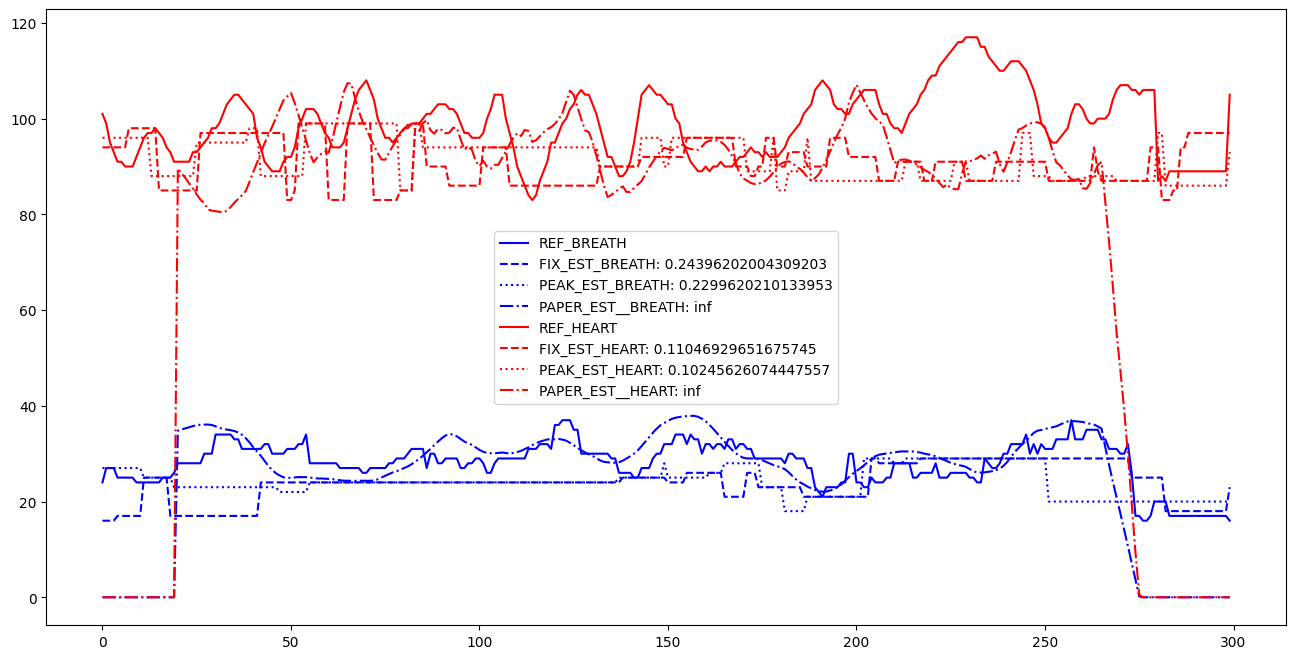

shape of input: (6000, 256)
[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 25.0, 25.0, 25.0, 25.0, 25.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 24.0, 24.0, 18.0, 18.0, 18.0, 18.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 18.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 32.0, 32.0, 32.0, 32.0, 32.0, 24.0, 24.0, 24.0, 24.0, 24.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0,

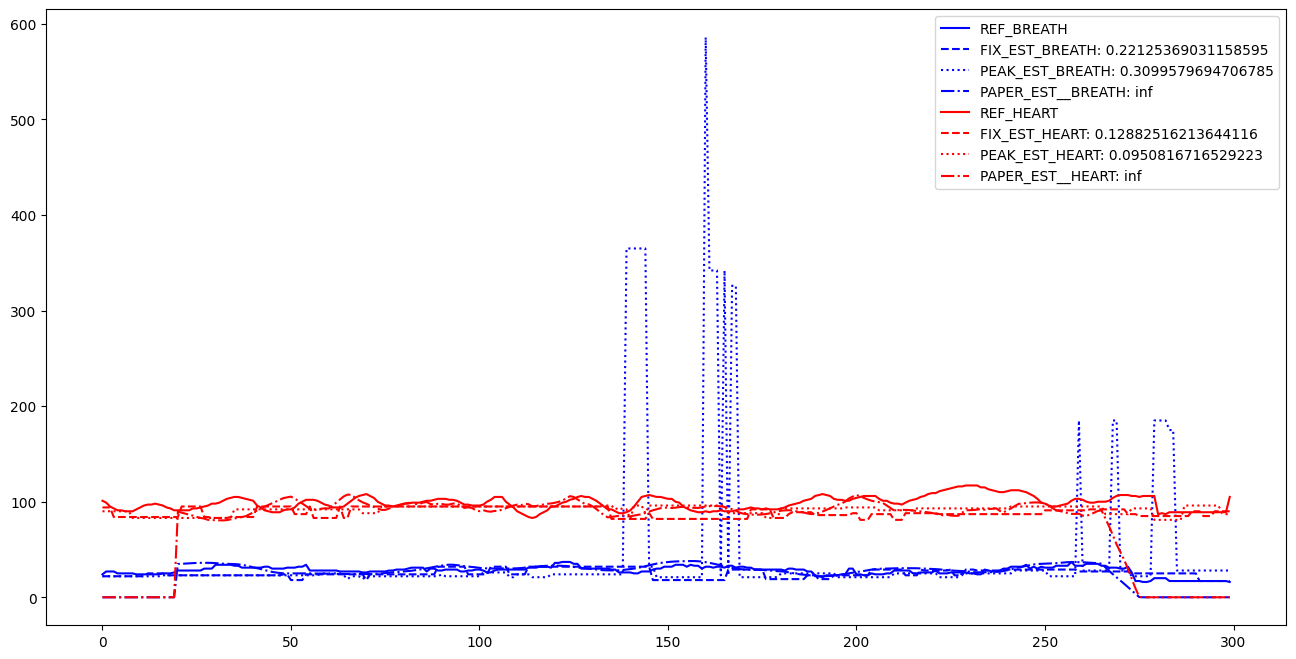

KeyboardInterrupt: 

In [47]:

for p in range(1,51):    
    PERSON_NUMBER=p
    breath_est_paper=read_est_file("../FMCW Radar/Heart Rate & Breathing Rate/Breath_{0}.csv".format(PERSON_NUMBER))
    heart_est_paper=read_est_file("../FMCW Radar/Heart Rate & Breathing Rate/Heart_{}.csv".format(PERSON_NUMBER))

    for channel_index in range(0,4):
        CHANNEL_INDEX=channel_index

        
        #read data
        file_path = '../FMCW Radar/Rawdata/Rawdata_{0}.csv'.format(PERSON_NUMBER)
        raw_data = readCsv(file_path)

        breaths=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Breath_{0}.csv".format(PERSON_NUMBER))
        heart=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Heart_{0}.csv".format(PERSON_NUMBER))
        
        
        data_channel=raw_data[channel_index]
        single_chirp_data =np.array([data_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)])
        double_chirp_data =np.array([data_channel[SAMPLE_PER_FRAME*i:SAMPLE_PER_FRAME*(i+1)]for i in range(0,FRAME_COUNT)])

        eveluate_channel =[]
        for ii in range(0,4):
            tmp_channel=raw_data[ii]
            eveluate_channel.append(np.array([tmp_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)]))

        #---------------------------------------------


        est_channel=single_chirp_data
        range_for_plotting =range(1,FFT_SIZE,2**3)
        range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]

        range_time_matrix=np.fft.fft(est_channel,axis=1)
        range_doppler_matrix=np.fft.fft2(est_channel)

        mag_range_time_matrix=np.abs(range_time_matrix)
        mag_range_doppler_matrix=np.abs(range_doppler_matrix)

        #---------------------------------------------

        column=range_time_matrix.shape[1]
        colum_FFT_range_fft_channel_0=np.zeros_like(range_time_matrix)
        for c in range(0,column):
            colum_FFT_range_fft_channel_0[:,c] =np.fft.fft(range_time_matrix[:,c])

        #---------------------------------------------

        peaks = get_the_peaks(mag_range_time_matrix)
        counts = np.bincount(peaks)
        dominant_bin_index =np.argmax(counts)
        
        signal_fixed_bin =est_channel[:,dominant_bin_index]
        signal_peak_bin=[]
        rows =range(0,est_channel.shape[0])
        colums =range(0,est_channel.shape[1])
        for r in rows:
            peak_r =peaks[r]
            signal_peak_bin.append(est_channel[r,peak_r])
        phase_unwrap_signal_fixed_bin=np.diff(np.unwrap(np.angle(signal_fixed_bin)))
        phase_unwrap_signal_peak_bin=np.diff(np.unwrap(np.angle(signal_peak_bin)))

        #---------------------------------------------

        EXTRACT_SAMPLING_RATE=20
        unwrap_fixed_breath=estSignal(phase_unwrap_signal_fixed_bin,EXTRACT_SAMPLING_RATE,float(20/60),float(40/60))
        unwrap_peak_breath=estSignal(phase_unwrap_signal_peak_bin,EXTRACT_SAMPLING_RATE,float(20/60),float(40/60))

        phase_unwrap_signal_fixed_bin_heart=filter_signal(phase_unwrap_signal_fixed_bin,80/60,100/60,EXTRACT_SAMPLING_RATE,4)
        phase_unwrap_signal_peak_bin_heart=filter_signal(phase_unwrap_signal_peak_bin,80/60,100/60,EXTRACT_SAMPLING_RATE,4)
        unwrap_fixed_heart=estSignal(phase_unwrap_signal_fixed_bin_heart,EXTRACT_SAMPLING_RATE,float(80/60),float(100/60))
        unwrap_peak_heart=estSignal(phase_unwrap_signal_peak_bin_heart,EXTRACT_SAMPLING_RATE,float(80/60),float(100/60))


        fixed_bin_freq_breath=estFreq(unwrap_fixed_breath)
        peak_bin_freq_breath=estFreq(unwrap_peak_breath)

        fixed_bin_freq_heart=estFreq(unwrap_fixed_heart)
        peak_bin_freq_heart=estFreq(unwrap_peak_heart)

        MAPE_FROM=21 
        MAPE_TO=270 

        mape_br_fix=MAPE(breaths[MAPE_FROM:MAPE_TO],fixed_bin_freq_breath[MAPE_FROM:MAPE_TO])
        mape_br_peak=MAPE(breaths[MAPE_FROM:MAPE_TO],peak_bin_freq_breath[MAPE_FROM:MAPE_TO])
        mape_br_paper=MAPE(breaths[MAPE_FROM:MAPE_TO],breath_est_paper[MAPE_FROM:MAPE_TO])

        mape_hr_fix=MAPE(heart[MAPE_FROM:MAPE_TO],fixed_bin_freq_heart[MAPE_FROM:MAPE_TO])
        mape_hr_peak=MAPE(heart[MAPE_FROM:MAPE_TO],peak_bin_freq_heart[MAPE_FROM:MAPE_TO])
        mape_hr_paper=MAPE(heart[MAPE_FROM:MAPE_TO],heart_est_paper[MAPE_FROM:MAPE_TO])


        plt.figure(figsize=(16,8))
        plt.plot(breaths[0:],label="REF_BREATH",color="blue")
        plt.plot(fixed_bin_freq_breath[0:],label="FIX_EST_BREATH: {0}".format(mape_br_fix),color="blue",linestyle='--')
        plt.plot(peak_bin_freq_breath[0:],label="PEAK_EST_BREATH: {0}".format(mape_br_peak),color="blue",linestyle='dotted')
        plt.plot(breath_est_paper[0:],label="PAPER_EST__BREATH: {0}".format(mape_br_paper),color="blue",linestyle='-.')
        

        plt.plot(heart[0:],label="REF_HEART",color="red")
        plt.plot(fixed_bin_freq_heart[0:],label="FIX_EST_HEART: {0}".format(mape_hr_fix),color="red",linestyle='--')
        plt.plot(peak_bin_freq_heart[0:],label="PEAK_EST_HEART: {0}".format(mape_hr_peak),color="red",linestyle='dotted')
        plt.plot(heart_est_paper[0:],label="PAPER_EST__HEART: {0}".format(mape_hr_paper),color="red",linestyle='-.')
        plt.legend()
        channel_folder="./RESULT_CHANNEL{0}".format(CHANNEL_INDEX)
        Path(channel_folder).mkdir(parents=True, exist_ok=True)
        plt.savefig('{1}/WAVELET{0}.png'.format(PERSON_NUMBER,channel_folder))

        plt.show()

